In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/latest/owid-covid-latest.csv'
covid_df = pd.read_csv(url)
print(covid_df.head())


   iso_code continent        location last_updated_date  total_cases  \
0       AFG      Asia     Afghanistan        2024-08-04     235214.0   
1  OWID_AFR       NaN          Africa        2024-08-04   13145380.0   
2       ALB    Europe         Albania        2024-08-04     335047.0   
3       DZA    Africa         Algeria        2024-08-04     272139.0   
4       ASM   Oceania  American Samoa        2024-08-04       8359.0   

   new_cases  new_cases_smoothed  total_deaths  new_deaths  \
0        0.0               0.000        7998.0         0.0   
1       36.0               5.143      259117.0         0.0   
2        0.0               0.000        3605.0         0.0   
3       18.0               2.571        6881.0         0.0   
4        0.0               0.000          34.0         0.0   

   new_deaths_smoothed  ...  male_smokers  handwashing_facilities  \
0                  0.0  ...           NaN                  37.746   
1                  0.0  ...           NaN               

In [2]:
# Load full time series
time_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df = pd.read_csv(time_url, parse_dates=['date'])

# Filter for India (or choose your country)
country = 'India'
india = df[df.location == country].copy()

# Check columns
print(india[['date','new_cases','new_deaths','new_tests','total_vaccinations']].tail())


             date  new_cases  new_deaths  new_tests  total_vaccinations
175226 2024-08-08        NaN         NaN        NaN        2.206868e+09
175227 2024-08-09        NaN         NaN        NaN        2.206868e+09
175228 2024-08-10        NaN         NaN        NaN        2.206868e+09
175229 2024-08-11        NaN         NaN        NaN        2.206868e+09
175230 2024-08-12        NaN         NaN        NaN        2.206868e+09


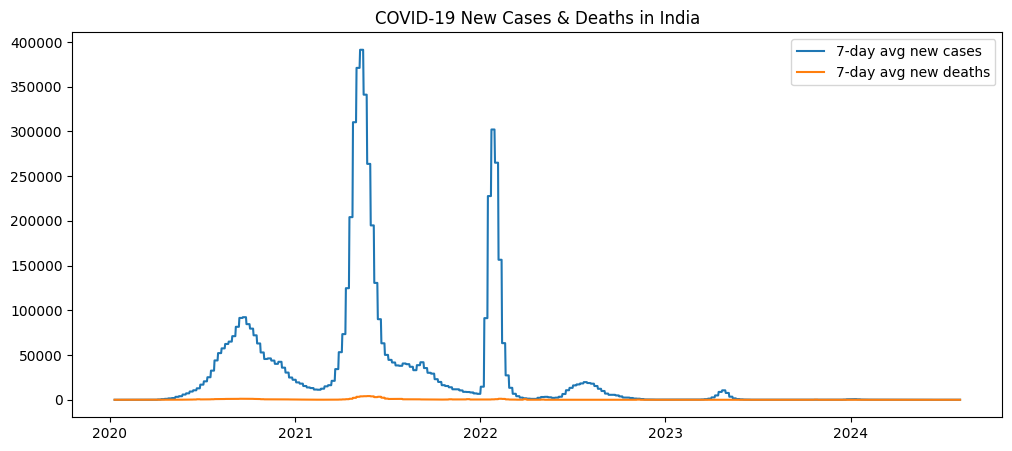

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(india.date, india.new_cases.rolling(7).mean(), label='7‑day avg new cases')
plt.plot(india.date, india.new_deaths.rolling(7).mean(), label='7‑day avg new deaths')
plt.title(f'COVID‑19 New Cases & Deaths in {country}')
plt.legend()
plt.show()


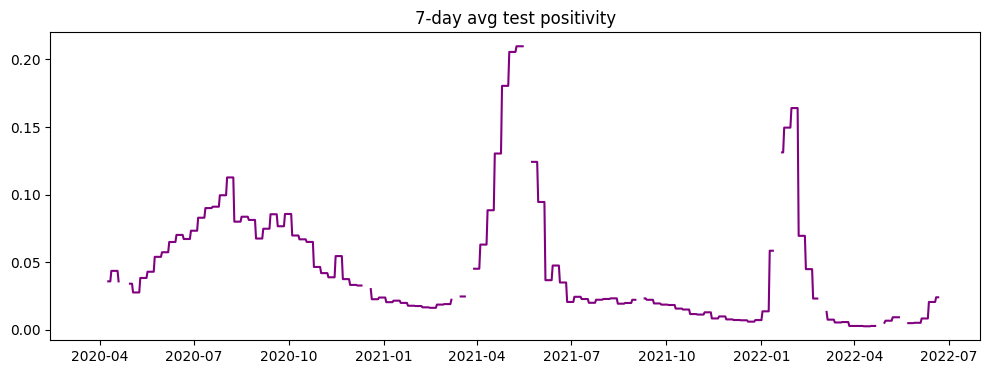

In [4]:
india['positivity'] = india.new_cases / india.new_tests
plt.figure(figsize=(12,4))
plt.plot(india.date, india.positivity.rolling(7).mean(), color='purple')
plt.title('7‑day avg test positivity')
plt.show()


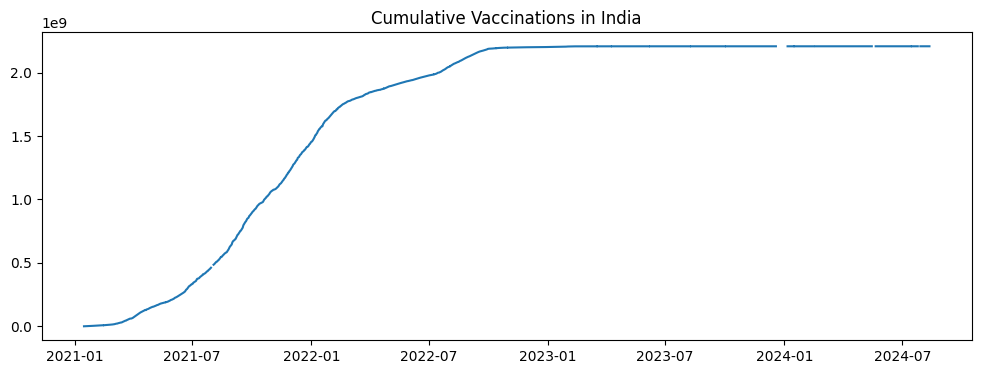

In [5]:
plt.figure(figsize=(12,4))
plt.plot(india.date, india.total_vaccinations)
plt.title('Cumulative Vaccinations in ' + country)
plt.show()


/tmp/ipython-input-7-305448753.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  india['new_cases_pct_change'] = india.new_cases.pct_change() * 100


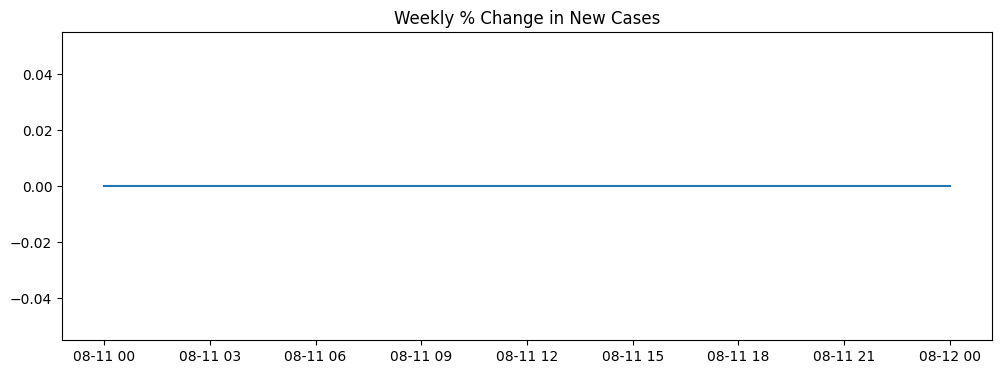

In [7]:
india['new_cases_pct_change'] = india.new_cases.pct_change() * 100
plt.figure(figsize=(12,4))
plt.plot(india.date, india.new_cases_pct_change.rolling(7).mean())
plt.title('Weekly % Change in New Cases')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                 1682
Model:                 ARIMA(7, 1, 0)   Log Likelihood              -20694.047
Date:                Sun, 13 Jul 2025   AIC                          41404.094
Time:                        06:46:29   BIC                          41447.511
Sample:                    01-05-2020   HQIC                         41420.176
                         - 08-12-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9966      0.131     -7.606      0.000      -1.253      -0.740
ar.L2         -0.9899      0.133     -7.436      0.000      -1.251      -0.729
ar.L3         -0.9832      0.134     -7.327      0.0

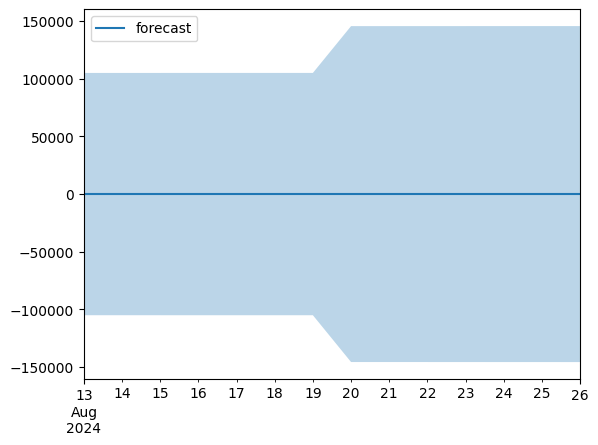

In [8]:
from statsmodels.tsa.arima.model import ARIMA

ts = india.set_index('date')['new_cases'].fillna(0)
model = ARIMA(ts, order=(7,1,0))  # basic weekly AR(7)
res = model.fit()
print(res.summary())

# Forecast next 14 days
f = res.get_forecast(steps=14)
ci = f.conf_int()
f.predicted_mean.plot(label='forecast'); plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.3)
plt.legend(); plt.show()


In [9]:
# Find dates with the highest number of new cases
top_days = india[['date', 'new_cases']].sort_values(by='new_cases', ascending=False).head(5)
print("Top 5 days with highest new cases:\n", top_days)


Top 5 days with highest new cases:
              date  new_cases
174039 2021-05-09  2738957.0
174032 2021-05-02  2597285.0
174046 2021-05-16  2387663.0
174025 2021-04-25  2172063.0
174298 2022-01-23  2115100.0


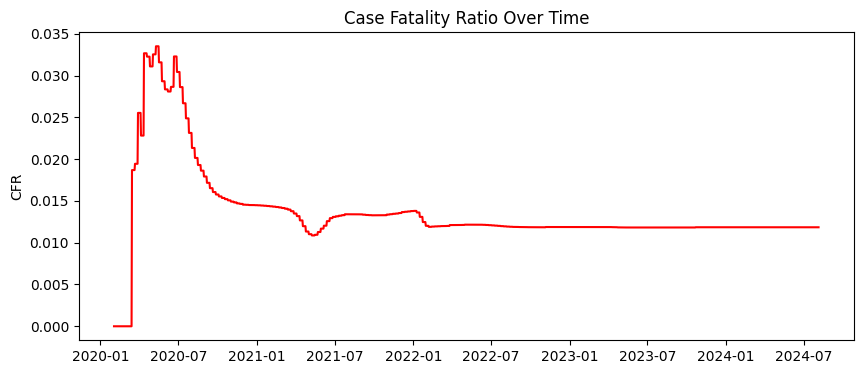

In [10]:
# CFR = total_deaths / total_cases
india['cfr'] = india.total_deaths / india.total_cases
plt.figure(figsize=(10,4))
plt.plot(india.date, india.cfr, color='red')
plt.title('Case Fatality Ratio Over Time')
plt.ylabel('CFR')
plt.show()


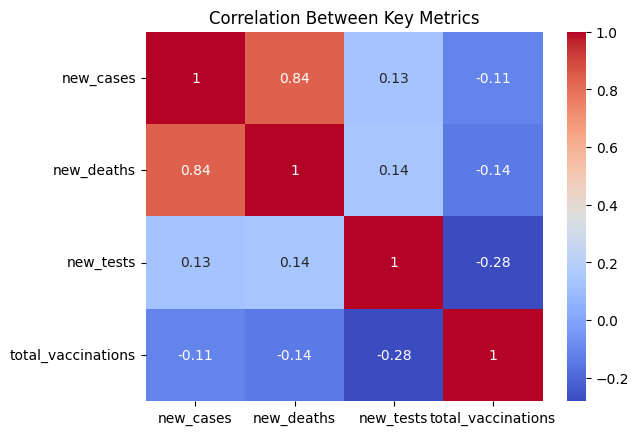

In [11]:
# Select relevant features
features = india[['new_cases', 'new_deaths', 'new_tests', 'total_vaccinations']].fillna(0)
corr_matrix = features.corr()

import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Key Metrics')
plt.show()


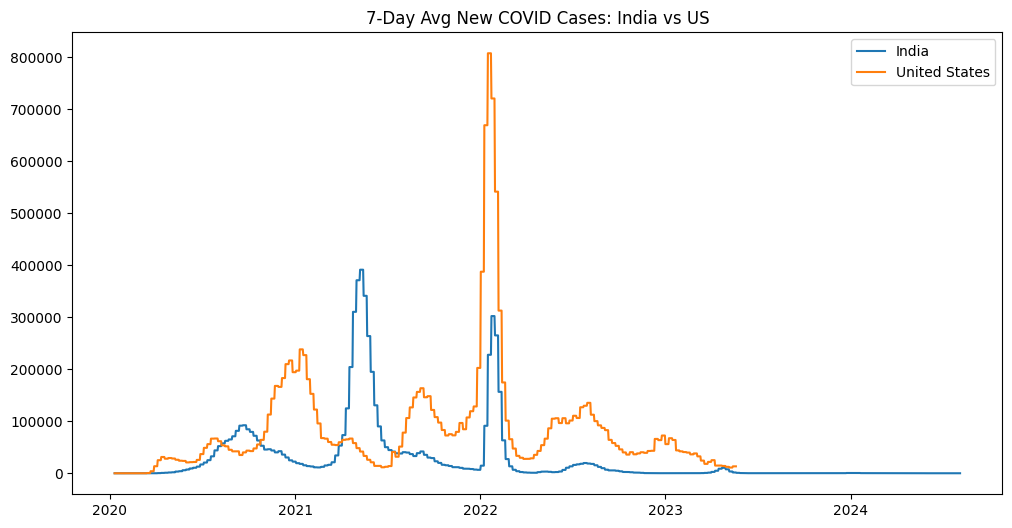

In [12]:
countries = ['India', 'United States']
multi_df = df[df['location'].isin(countries)][['location', 'date', 'new_cases']]

# Smooth and plot
plt.figure(figsize=(12,6))
for country in countries:
    temp = multi_df[multi_df.location == country]
    plt.plot(temp.date, temp.new_cases.rolling(7).mean(), label=country)

plt.legend()
plt.title('7-Day Avg New COVID Cases: India vs US')
plt.show()


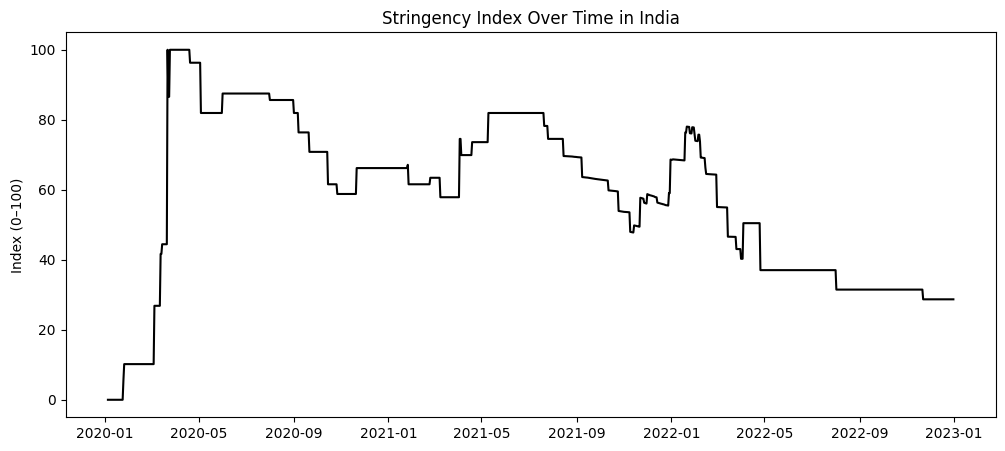

In [13]:
# OWID data includes stringency index
plt.figure(figsize=(12,5))
plt.plot(india.date, india.stringency_index, label='Government Response (Stringency Index)', color='black')
plt.title('Stringency Index Over Time in India')
plt.ylabel('Index (0–100)')
plt.show()


In [14]:
import plotly.express as px

# Interactive line chart of cases
fig = px.line(india, x='date', y='new_cases', title='Daily New COVID Cases in India')
fig.update_traces(line=dict(color='royalblue'))
fig.show()
